### SI Model

In this file, we will model a Susceptible-Infected (SI) model with demographics.

The equations we use are as follows:

$$
\begin{align*}
\dot{Sj} &= B(t)*Sa-\beta j(t)*Sj*Ia-\theta*Sj*(Sa+Ia)-m*Sj-d*Sj\\
\dot{Sa} &= m*Sj-\beta a(t)*Sa*Ia-d*Sa\\
\dot{Ij} &= \beta(t) j*Sj*Ia-m*Ij-d*Ij\\
\dot{Ia} &= m*Sj+\beta a(t)*Sa*Ia-d*Ia\\
\end{align*}
$$

Where $Sj$ is the number of susceptible juveniles, $Sa$ is the number of susceiptble adults, $Ij$ is the number of infected juveniles, and $Ia$ is the number of infected adults.
The model also has parameters, with $\beta$ for the transmission rate, $\theta$ for the densidy dependent control, $B(t)$ for the birth rate, $D(t)$ for the death rate, and $M$ as the maturity rate.

This code below implements a numerical solution to this model model.
To run this code, we will use the numpy package for handeling arrays, the solve_ivp function from scipy to handle the numerical solving, and matplotlib for plotting.

In [346]:
import numpy as np
import math

from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from matplotlib import pyplot as plt

The following code represents some helper functions that serve as parameters for the model. 

The birth() fuction creates a seasonal birth pulse and returns the corresponding birth rate given the current time, the start of the pulse, the end of the pulse, the wanted average birth rate, and the base birth rate. This function uses two tanh equations to provide a fast "pulse" that can be controlled with a few parameters. The birthVector() function is a helper method that is used for graphing the results.

The pointTanH() function creats a seasonal pulse for the $\beta$ function in the initial equations. Given the same parameters as the birth() function, pointTanH similarly returns a value that corresponds to the tanH equations with the parameters given. vectorTanH() is used for graphing as well, but can be given an array of time points and will return another array of the same size with the wanted values.

In [347]:
def birth(t, start, end, mid, base):
    time = t%3650
    tmid=(start+end)/2
    if(time<tmid):
        x=mid*np.tanh(time-start)+mid+base
    else:
        x=mid*np.tanh(-(time-end))+mid+base
    return x

def birthVector(t, start, end, mid, base):
    births=np.zeros(len(t))
    for i, t_point in enumerate(t):
        births[i]=birth(t_point, start, end, mid, base)
    return births

def pointTanH(t, start, end, mid, base):
    time=t%3650
    tmid=(start+end)/2
    if(time<tmid):
        x=mid*np.tanh(time-start)+mid+base
    else:
        x=mid*np.tanh(-(time-end))+mid+base
    return x

def vectorTanH(t, start, end, mid, base):
    betas=np.zeros(len(t))
    for i, t_point in enumerate(t):
        betas[i]=pointTanH(t_point,start,end, mid, base)
    return betas



First, we can create a function which takes in the state of the system and returns the rate of change for each compartment with differential equations.

In [348]:
def SI(t, X, Bj, Ba, theta, death, maturity, startJ, endJ, startA, endA, startB, endB, midB, baseB, baseJ, baseA):
    '''
    Inputs:
        t: The time state variable for non-autonomous systems, not used here but required by solve_ivp
        X: Vectorized state variables where X = (Sj, Sa, Ij, Ia)
        Bj: Transmission rate parameter for juveniles
        Ba: Transmission rate parameter for adults
        theta: Population density negation parameter
        death: Death rate parameter
        maturity: Maturity rate parameter
        startJ: Initial time of the juvenile transmission pulse 
        endJ: Final time of the juvenile transmission pulse
        startA: Initial time of the adult transmission pulse
        endA: Final time of the adult transmission pulse
        startB: Initial time of the birth pulse
        endB: Final time of the birth pulse
        midB: The average birth rate wanted
        baseB: The base birth rate wanted before or after the pulse
        baseJ: The base juvenile transmission rate wanted before or after the pulse
        baseA: The base adult transmission rate wanted before or after the pulse

    Returns:
        (dSj, dSa, dIj, dIa): Tuple of the rates of change for each state variable
    '''

 
    #Unpack the tuple containing the values for S, I, and R
    Sj, Sa, Ij, Ia = X

    dSj=birth(t, startB, endB, midB, baseB)*Sa-baseJ*Sj*Ia-theta*Sj*(Sa+Ia)-maturity*Sj-death*Sj
    dSa=maturity*Sj-baseA*Sa*Ia-death*Sa
    dIj=baseJ*Sj*Ia-maturity*Ij-death*Ij
    dIa=maturity*Ij+baseA*Sa*Ia-death*Ia


    # The differential equations themselves
    # dSj=birth(t, startB, endB, midB, baseB)*Sa-pointTanH(t,startJ,endJ, Bj, baseJ)*Sj*Ia-theta*Sj*(Sa+Ia)-maturity*Sj-death*Sj
    # dSa=maturity*Sj-pointTanH(t,startA,endA,Ba, baseA)*Sa*Ia-death*Sa
    # dIj=pointTanH(t,startJ,endJ, Bj, baseJ)*Sj*Ia-maturity*Ij-death*Ij
    # dIa=maturity*Ij+pointTanH(t,startA,endA,Ba, baseA)*Sa*Ia-death*Ia


    return (dSj, dSa, dIj, dIa)

Next, we define a few values needed to run the simulation.
First we define the initial conditions with `X_0`.
This describes the starting number for each of our three compartments (susceptible, infected and recovered).
For systems with a global attractor (a single globally stable equilibrium), the initials conditions do not matter for the final equilibirum, but this is not the case for our SIR model.

Next, we define a variable `t`, which is a tuple with two values.
The first value is the initial time point and the second is the final time point.
This tells the numerical solver the time range over which to produce a solution.

Finally, we set values for our two simulation parameters, beta and gamma for the transmission rate and recovery rate.

In [349]:
#Set the initial conditions for the number of susceptible, infected and recovered individuals
X_0 = (10, 50, 10, 5)
#10,50,10,5
#Set the time range over which to solve the system
t = (0, 100)

#Set the variable parameters
#BIRTHS:
startB=12
endB=100
baseB=.35
midB=.05

#JUVENILE TRANSMISSION
startJ=33
endJ=53
baseJ=.004
Bj = 0.002

#ADULT TRANSMISSION
startA=65
endA=90
baseA=.002
Ba=.002

#OTHER
theta = 0.001
death = .2
maturity=.3




Now we are ready to compute our solution. To do this, we use the `solve_ivp` function from scipy.
This takes in several paramters:
1. The function that returns the differentials (SIR)
2. The time range to compute the solution
3. The initial conditions
4. A tuple of parameters

We have also defined an addition keyword argument, `max_step`, which is not strictly necesary, but can be used to produce smoother results.
The `solve_ivp` function returns a class structure which has several important attributes:
- solution.y: a matrix of results where the rows are the compartments and the columns are the time points
- solution.t: the time points at which the solution is calcuated (depending on the algorithm, they may not be evenly spaced)

In [350]:
#Run the solve_ivp function to get a numerical solution
solution = solve_ivp(SI, t, X_0, args=(Bj, Ba, theta, death, maturity, startJ, endJ, startA, endA, startB, endB, midB, baseB, baseJ, baseA), max_step=0.1)

Sj = solution.y[0, :]
Sa = solution.y[1, :]
Ij = solution.y[2, :]
Ia = solution.y[3, :]

time_points = solution.t

#Solve for optimal pathogen evolution, in which the set width of the juvenile transmission peak slides through the entire t=0 to t=3650. 
increment=100#Number of times the model will run, SHOULD BE ABOVE 0
betaRange=endJ-startJ
short_time=np.linspace(time_points[0], time_points[-1], increment)
deltas=np.zeros(len(short_time))
proportions=np.zeros(len(short_time))
integrals=np.zeros(len(short_time))
print("Length: "+str(len(short_time)))
for i, t_point in enumerate(short_time):
    temp_solution=solve_ivp(SI, t, X_0, args=(Bj, Ba, theta, death, maturity, t_point, t_point+betaRange, startA, endA, startB, endB, midB, baseB, baseJ, baseA), max_step=0.1)
    # maxSa=0
    # minSa=1000
    # maxIa=0
    # minIa=1000
    # for temp_t in range(int(len(temp_solution.y[1,:])*.9), int(len(temp_solution.y[1,:]))):
    #     if(temp_solution.y[1, :][temp_t]>maxSa):
    #         maxSa=temp_solution.y[1, :][temp_t]
    #     elif(temp_solution.y[1, :][temp_t]<minSa):
    #         minSa=temp_solution.y[1, :][temp_t]
    #     if(temp_solution.y[3, :][temp_t]>maxIa):
    #         maxIa=temp_solution.y[3, :][temp_t]
    #     elif(temp_solution.y[3, :][temp_t]<minIa):
    #         minIa=temp_solution.y[3, :][temp_t]
    # finalSa=(maxSa+minSa)/2
    # finalIa=(maxIa+minIa)/2

    totIa=integrate.simps(temp_solution.y[3, :], x=temp_solution.t, axis=-1, even='avg')
    finalSa=temp_solution.y[1, :][-1]
    finalIa=temp_solution.y[3, :][-1]
    delta=finalSa-finalIa
    # print("Solution length: "+str(len(temp_solution.y[1,:]))+"and"+str(len(temp_solution.y[3,:])))
    #The graphed value is the final proportion of susceptible adults out of all adult plants, effectively seeing how successful the virus was
    proportion=finalSa/(finalSa+finalIa)
    print("Current total: "+str(totIa)+",current proportion: "+str(proportion)+", current I:"+str(i)+", current t: "+str(t_point)+", calculated Sa: "+str(finalSa)+", true Sa:"+str(temp_solution.y[1, :][-1]))
    deltas[i]=delta
    proportions[i]=proportion
    integrals[i]=totIa

Length: 100
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:0, current t: 0.0, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:1, current t: 1.0101010101010102, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:2, current t: 2.0202020202020203, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:3, current t: 3.0303030303030303, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:4, current t: 4.040404040404041, calculated Sa: 35.88051709183489, true Sa:35.88051709183489


/var/folders/jk/jjsz169j635_4flxb1lg15cm0000gn/T/ipykernel_15929/1695801442.py:37: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  totIa=integrate.simps(temp_solution.y[3, :], x=temp_solution.t, axis=-1, even='avg')


Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:5, current t: 5.050505050505051, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:6, current t: 6.0606060606060606, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:7, current t: 7.070707070707071, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:8, current t: 8.080808080808081, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:9, current t: 9.090909090909092, calculated Sa: 35.88051709183489, true Sa:35.88051709183489
Current total: 961.7682908188578,current proportion: 0.7682279130935029, current I:10, current t: 10.101010101010102, c

Finally, we can graph the solution using the matplotlib package

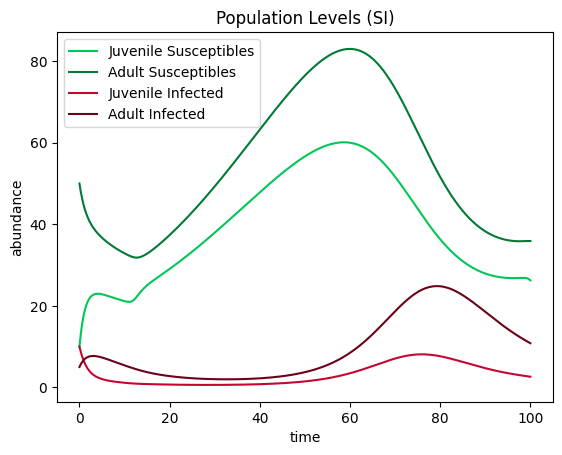

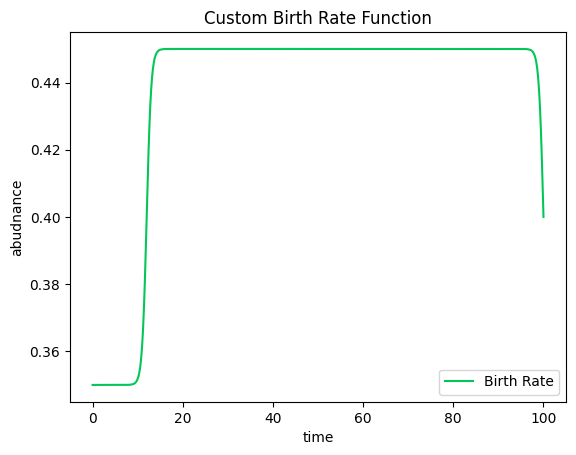

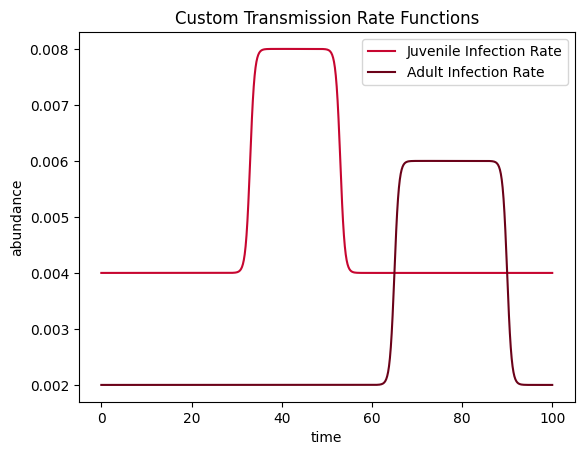

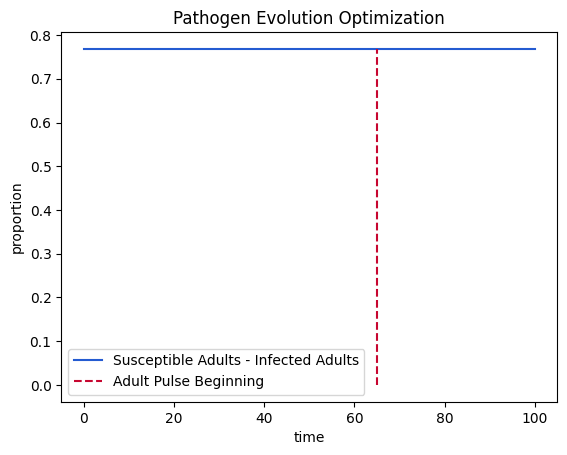

In [351]:
colSj='#02c757'
colSa='#017a36'
colIj='#c70630'
colIa='#6b0219'
colTot='#245bd1'

#The first graph represents the population levels of each demographic accross the timescale
fig, populationGraph = plt.subplots()
populationGraph.set_title('Population Levels (SI)')
populationGraph.plot(time_points, Sj, label='Juvenile Susceptibles', color=colSj)
populationGraph.plot(time_points, Sa, label='Adult Susceptibles', color=colSa)
populationGraph.plot(time_points, Ij, label='Juvenile Infected', color=colIj)
populationGraph.plot(time_points, Ia, label='Adult Infected', color=colIa)
# populationGraph.plot(time_points, Sj+Sa+Ij+Ia, label='Total', color=colTot)
# populationGraph.plot((startJ, startJ+.000000001), (0, max(Sa)), '--', color=colIj)
# populationGraph.plot((endJ, endJ+.000000001), (0, 100), '--', color=colIj)
# populationGraph.plot((startA, startA+.000000001), (0, max(Sa)), '--', color=colIa)
# populationGraph.plot((endA, endA+.000000001), (0, 150), '--', color=colIa)
populationGraph.set_xlabel('time')
populationGraph.set_ylabel('abundance')
populationGraph.legend()

#This graph represents the birth levels of each demographic across the timescale, DOES NOT WORK AS INTENDED
# fig, birthGraph = plt.subplots()
# birthGraph.set_title('Growth Levels')
# birthGraph.plot(time_points, midB*Sa, label='Sj Growth', color=colSj)
# birthGraph.plot(time_points, maturity*Sj, label='Sa Growth', color=colSa)
# birthGraph.plot(time_points, Bj*Sj*Ia, label='Ij Growth', color=colIj)
# birthGraph.plot(time_points, maturity*Ij+Ba*Sa*Ia, label='Ia Growth', color=colIj)
# birthGraph.set_xlabel('time')
# birthGraph.set_ylabel('abundance')
# birthGraph.legend()

#This graph represents the death levels of each demographic across the timescale, DOES NOT WORK AS INTENDED
# fig, deathGraph = plt.subplots()
# deathGraph.set_title('Death Levels')
# deathGraph.plot(time_points, theta*S*(S+I)+death*S, label='Susceptible Deaths Per Day', color='#23a81e')
# deathGraph.plot(time_points, death*I, label='Infected Deaths Per Day', color='#c70630')
# deathGraph.set_xlabel('time')
# deathGraph.set_ylabel('abundance')
# deathGraph.legend()

#The second graph represents the current birth pulse function
fig, custom = plt.subplots()
custom.set_title('Custom Birth Rate Function')
custom.plot(time_points, birthVector(time_points, startB, endB, midB, baseB), label='Birth Rate', color=colSj)
custom.plot()
custom.set_xlabel('time')
custom.set_ylabel('abudnance')
custom.legend()

#The third graph represenents both tramission pulse functions
fig, custom2 = plt.subplots()
custom2.set_title('Custom Transmission Rate Functions')
custom2.plot(time_points, vectorTanH(time_points, startJ, endJ, Bj, baseJ), label='Juvenile Infection Rate', color=colIj)
custom2.plot(time_points, vectorTanH(time_points, startA, endA, Ba, baseA), label='Adult Infection Rate', color=colIa)
custom2.plot()
custom2.set_xlabel('time')
custom2.set_ylabel('abundance')
custom2.legend()

#The fourth graph represents the optimization points of the pathogen, showing how successful was if the pathogen peak started at that t value
fig, pathogenEvolution = plt.subplots()
pathogenEvolution.set_title('Pathogen Evolution Optimization')
pathogenEvolution.plot(short_time, proportions, label='Susceptible Adults - Infected Adults', color=colTot)
# pathogenEvolution.plot((startJ, startJ+.000000001), (0, 100), '--', color=colIj)
pathogenEvolution.plot((startA, startA+.000000001), (0, max(proportions)), '--', color=colIj, label='Adult Pulse Beginning')
pathogenEvolution.plot()
pathogenEvolution.set_xlabel('time')
pathogenEvolution.set_ylabel('proportion')
pathogenEvolution.legend()
